[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/demo_notebooks/8_nb_ensemble_learning.ipynb) 


# Chapter 8 - Ensemble learning 
We covered classification and regression trees in [Demo Notebook 5](https://github.com/Humboldt-WI/bads/blob/master/demo_notebooks/5_nb_supervised_learning.ipynb) on supervised learning. Today, we will look into ways for improving the predictive power of tree-based classifiers through *ensemble learning*. Recall that an ensemble is a **collection of multiple base models**. The base models are prediction models on their own. In a homogeneous ensemble, we produce the base models with the same supervised learning algorithm whch is the focus of this demo notebook. Our underlying learning algorithm will be a classification tree. 

The lecture introduced three popular homogeneous ensemble frameworks: bagging, random forest, and boosting. We also learned that the last framework is often implemented using *Adaboost* or, more recently, *gradient boosting*. The goal of the demo notebook is to demonstrate how these ensemble learning frameworks work. In order to do this, we provide **implementations of multiple ensemble learners from scratch**. Another goal is to empower you to use ensemble algorithms in your work/studies. We pursue this goal by walking you through coding demos on **how to train, tune, and apply ensemble learning algorithms** using `sklearn` and other libraries. 


The outline of the demo notebook is as follows:
- Preliminaries
- Random Forest (homogeneous ensemble)
- Boosting principles
- Gradient boosting from scratch
- XGBoost with xgb

# Preliminaries
We begin as usual with importing our standard libraries and also our standard modeling data. Since we are also familiar with data organization by now, we will also use `sklearn`'s functionality to partition our data into a training and a test set. 

In [2]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# Load credit risk data in pre-processed format from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col="index")

# Pretty printing
from pprint import pprint

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)
print("Remember the shape of our data: ")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Remember the shape of our data: 
(4172, 18) (4172, 1) (1788, 18) (1788, 1)


# Random forest
Even more effective for predictions than decision trees, random forests (RF) are useful and powerful ensemble methods for classifying and regressing data. Essentially, a random set of the features are taken to build decision trees. Trees are also built using *bagged data* which are samples of the data taken with replacement. Many trees are grown (sometimes their maximum depth is also specified) and then all trees vote on the response. Each tree's vote generally has the same weight.


## Random forest from scratch
Though most of the the time we'd use `sklearn`  to implement RF, it is useful to take a look at the inner workings of the algorithm. Given that RF is an extension of the *bagging algorithm*, we will not look into bagging separately but cover bagging as part of RF.

### Helper Functions for Individual Trees

Again, a RF model is a collection of individual decision trees. So let's start with a recap of how an individual tree works with our data:

We face a classification problem. Thus, the goal of growing a tree is to obtain leaf nodes in which the class distribution is pure. Many potential ways to split the data are calculated (eg. the algorithm below finds all unique values of each column and then the midpoint between sequential values). For each potential split, we assess its ability to separate the classes. More specifically, we calculate the **impurity** of the parent node and compare it with the sum of the impurity scores of the child nodes which would result from the candidate split. We also weigh the child nodes' impurity scores by the number of cases (data points) that enter the left and right child node, respectively. 

There are three major impurity functions: **entropy, gini, and misclassification error**. We use entropy in our example. The split which yields the lowest impurity is chosen and the process is repeated for the new nodes (this is also known as recursion). 

The method of choosing the split that yields the lowest impurity is called the **greedy search method**. The following functions will help the decision tree implement greedy search tactics on the data. The algorithm stops either when the purity in each node is reached or when it has reached a maximum depth (max amount of recursions we allow) specified in our function.

Many functions for the tree are not found in Python packages and it is cleaner to write them out first then put them together in our main algorithm. Each function below does a specific action, which will be used in our final tree function at the end. Most functions are just copy & pasted from [Demo Notebook 5](https://github.com/Humboldt-WI/bads/blob/master/demo_notebooks/5_nb_supervised_learning.ipynb). Changes in the function will be seen in the next mini-section, we will highlight all of them.

In [3]:
def check_purity(y):
    
    'checks if a leaf node is perfectly pure, in other words, if the leaf node contains only one class'
    
    unique_classes = np.unique(y)  # Count number of classes in section of data

    if len(unique_classes) == 1:  # Check if the node is pure
        return True
    else:
        return False

In [4]:
def classify_data(y):
    
    'classifies data according to the majority class of each leaf'
    
    unique_classes, counts_unique_classes = np.unique(y, return_counts=True)
    # Returns classes and no. of obs per class

    index = counts_unique_classes.argmax() # Index of class with most obs
    classification = unique_classes[index] # Class chosen for classification which is class with most obs
    
    return classification

In [5]:
def split_data(X, y, split_column, split_value):
    
    'splits data based on specific value, will yield both a split for the features X and target y'
    
    split_column_values = X[:, split_column]

    X_below = X[split_column_values <= split_value]  # Partitions data according to split values from previous functions
    X_above = X[split_column_values >  split_value]
    
    y_below = y[split_column_values <= split_value]
    y_above = y[split_column_values >  split_value]
    
    return X_below, X_above, y_below, y_above

In [6]:
def calculate_entropy(y):
    
    'calculates entropy for each partition of data'
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()  # Probability of each class
    entropy = sum(probabilities * -np.log2(probabilities))  # Could replace with Gini impurity or misclassification
     
    return entropy

In [7]:
def calculate_overall_entropy(y_below, y_above): 
    
    'calculates the total entropy after each split'
       
    n = len(y_below) + len(y_above)
    p_data_below = len(y_below) / n
    p_data_above = len(y_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(y_below)
                      + p_data_above * calculate_entropy(y_above))
    
    return overall_entropy

In [8]:
def determine_best_split(X, y, potential_splits):
    
    'selects which split lowered entropy the most'
    
    overall_entropy = 9999  # Set arbitrarily high, the function will loop over and replace this with lower impurity values
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            X_below, X_above, y_below, y_above = split_data(X, y, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(y_below, y_above)
            
            # Goes through each potential split and only updates if it lowers entropy

            if current_overall_entropy <= overall_entropy: 
                overall_entropy = current_overall_entropy # Updates only if lower entropy split found, in the end this is greedy search
                best_split_column = column_index
                best_split_value = value
            
    
    return best_split_column, best_split_value

#### Random subspace
Recall a distinct feature of RF in addition to bagging. The algorithm for growing base model trees in RF does not search for the next best split among ALL features. Instead, it first draws a random subset of features and then finds the next best split among this subset. This mechanism is called random subspace and was introduced in [Ho's 1998 paper](http://dx.doi.org/10.1109/34.709601). 

Random subspace does not make sense when growing an individual tree. Thus, we did not cover the approach in  [Demo Notebook 5](https://github.com/Humboldt-WI/bads/blob/master/demo_notebooks/5_nb_supervised_learning.ipynb). However, random subspace is a vital ingredient to RF and it is best implemented in function to get potential splits. Therefore, we adjust the implementation of `get_potential_splits()` compared to the [Demo Notebook 5](https://github.com/Humboldt-WI/bads/blob/master/demo_notebooks/5_nb_supervised_learning.ipynb) version, to ready our code for RF. Note that our updated implementation does not use random subspace by default but can activate it easily by setting the corresponding argument. Thus, our implementation supports both vanilla trees and trees with a random subspace.   

In [9]:
def get_potential_splits(X, random_subspace = None):
    
    'first, takes every unique value of every feature in the feature space, then finds the midpoint between each value'
    'modified to add random_subspace for random forest'
    
    potential_splits = {}
    _, n_columns = X.shape  # No need for rows, we choose the column to split on
    # Only need second value of .shape which is columns
    column_indices = list(range(n_columns))
    
    if random_subspace and random_subspace <= len(column_indices):  # Randomly chosen features
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:
        potential_splits[column_index] = [] 
        values = X[:, column_index] 
        unique_values = np.unique(values)  # Get all unique values in each column

        for index in range(len(unique_values)):  # All unique feature values
            if index != 0:  # Skip first value, we need the difference between next values
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]  # Find a value and the next smallest value
                potential_split = (current_value + previous_value) / 2  # Find difference between the two as a potential split
                
                # Consider all values which lie between two values as a potential split
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

The tree will now implement the helper functions and display the decision which yielded the best split if printed.

In [10]:
def decision_tree_algorithm(X, y, counter=0, min_samples=2, max_depth=5, random_subspace = None): 

    'same function as in the Decision Tree notebook but now we add random_subspace argument'

    # Data preparation
    if counter == 0:  # Counter tells us how deep the tree is, this is before the tree is initiated
        global COLUMN_HEADERS
        COLUMN_HEADERS = X.columns
        X = X.values  # Change all to NumPy array for faster calculations
        y = y.values
    else:
        data = X  # If we have started the tree, X should already be a NumPy array from the code above 

    # Base cases
    if (check_purity(y)) or (len(X) < min_samples) or (counter == max_depth):
        classification = classify_data(y)

        return classification

    # Recursive part
    else:    
        counter += 1  # Tells us how deep the tree is

          # Helper functions 
        potential_splits = get_potential_splits(X, random_subspace)  # Check for all possible splits ONLY using the random subspace and not all features!

        if bool([feature_splits for feature_splits in potential_splits.values() if feature_splits != []]): # Checks that potential_splits is not just a blank dictionary (occurs when random feature subspace has no variation in observations)
            best_split_column, best_split_value = determine_best_split(X, y, potential_splits)  # Select best split based on entropy
            X_below, X_above, y_below, y_above = split_data(X, y, best_split_column, best_split_value)  # Execute best split

            # Code to explain decisions made by tree to users
            feature_name = COLUMN_HEADERS[best_split_column]
            question = "{} <= {}".format(feature_name, best_split_value) # Initiate explanation of split
            sub_tree = {question: []}

            # Pull answers from tree
            yes_answer = decision_tree_algorithm(X_below, y_below, counter, min_samples, max_depth, random_subspace)
            no_answer = decision_tree_algorithm(X_above, y_above, counter, min_samples, max_depth, random_subspace)

            # Ensure explanation actually shows useful information
            if yes_answer == no_answer: # If decisions are the same, only display one
                sub_tree = yes_answer
            else:
                sub_tree[question].append(yes_answer)
                sub_tree[question].append(no_answer)

        else: # If there are no splits possible (no variation in subset of data), classify the data at this point
            classification = classify_data(y)
            return classification

        return sub_tree

### Helper functions for the Random Forest Algorithm
Now that we have the structure to build one individual classification tree, we can make use of it to grow a full forest of trees. However, the **strength-diversity trade-off** suggests that a naive combination of base models will not give a powerful ensemble model. Rather, for an ensemble learner to work well, we need base models that display both strength and diversity. RF fosters diversity among its base models by **randomizing tree growing**. So, we grow a forest of random trees. Specifically, the two mechanisms of randomization in RF are **bootstrap sampling** and **random subspace**. To implement the corresponding functionality, we will use the `random` library.  

In [11]:
import random

Using this library, we can implement our bootstrap sampling mechanism as follows. Remember that a bootstrap sample is nothing but a random sample of the same size as the original data drawn *with replacement*. 

In [12]:
def bootstrapping(X, y, n_bootstrap):
  
    'takes a random set of observations of the size n_bootstrap'

    bootstrap_indices = np.random.randint(low=0, high=len(X), size=n_bootstrap)  # Chooses random indices for the sample
    X_bootstrapped = X.iloc[bootstrap_indices]
    y_bootstrapped = y.iloc[bootstrap_indices]
    
    return X_bootstrapped, y_bootstrapped

Once we have all this structure in place, the actual implementation of the RF algorithm is straightforward. All we need to do is to grow as many base model trees as we'd like and make sure we activate **random subspace** when growing the individual member trees from a **bootstrap sample** of the training data. In addition to the number of trees and number of features to consider for random subspace, our implementation also allows the user to specify the size of the bootstrap sample, which is useful to accelerate the algorithm, and the maximum depth of the tree models. While this offers some flexibility, professional implementations of the RF algorithm offer many more parameters.   

In [13]:
def random_forest_algorithm(X, y, n_trees, n_bootstrap, n_features, dt_max_depth):
    'puts the bootstrap sample in the decision tree algorithm with max depth and the random subset of features set, in otherwords, builds the forest tree by tree'
    forest = []
    for i in range(n_trees): #loops for the amount of trees set to be in the forest
        X_bootstrapped, y_bootstrapped = bootstrapping(X, y, n_bootstrap)
        tree = decision_tree_algorithm(X_bootstrapped, y_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features) #creates individual trees
        forest.append(tree)
    
    return forest

Being almost ready to develop an  RF classifier, the only missing bit is some functionality to apply the trained model to new data. We split this into two functions. The first function, `predict_example`, predicts a single sample from a single tree. The second, `decision_tree_predictions`, uses `predict_example` and makes predictions for every tree in the forest. When a function's main purpose is to use another function to perform a task, it is called a wrapper function. In tihs case, `decision_tree_predictions` is a wrapper function.

In [14]:
def predict_example(example, tree, counter=0):

    'takes one observation and predicts its class'
    
    if counter == 0 and isinstance(tree, dict) == False: # very shallow trees may only vote one way, this first if-statement takes its vote into account
        return tree
    
    else:
        counter += 1
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # Ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # Feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # Base case
    if not isinstance(answer, dict):
        return answer
    
    # Recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
# Gathers all test data
def decision_tree_predictions(test_df, tree):
  
    'applies predict_example to all of the test set'

    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

Now that we have a function to make predictions for every tree in the forest, we are going to collect those predictions and take the mode prediction. This will be the final prediction for our forest.

In [15]:
def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)  # Key for dictionary
        predictions = decision_tree_predictions(test_df, tree=forest[i])  # Predictions from trees
        df_predictions[column_name] = predictions  # Insert predictions into dictionary

    df_predictions = pd.DataFrame(df_predictions)  # Change dictionary to pandas DF
    random_forest_predictions = df_predictions.mode(axis=1)[0]  # Take mode of predictions over trees for final prediction
    # If there is an even number of predictions, just default to the first value (very unlikely with many trees)
    
    return random_forest_predictions

### Ready, stready, go...
Well done, we have our custom-code RF classifier up and ready. Time to put it into action and produce some credit default risk predictions. Since our implementation is maybe not the most efficient one, let's stick to shallow trees and also set the other hyperparameters such that run times are bearable.   

In [16]:
# Grow RF 
forest = random_forest_algorithm(X, y, n_trees=100, n_bootstrap=800, n_features=5, dt_max_depth=5)

In [17]:
# Depict one member tree as rule set
forest[0]

{'DEROGzero <= 0.5': [{'LOAN <= -1.3837211287939664': [True,
    {'REASON_IsMissing <= 0.5': [{'DEBTINC <= 0.1332301766018364': [False,
        True]},
      False]}]},
  {'MORTDUE <= -0.8183559985529485': [{'DELINQcat_1 <= 0.5': [{'LOAN <= -0.6865586694647503': [{'VALUE <= -1.0706886081536031': [True,
          False]},
        False]},
      {'NINQ <= -0.44592340686699494': [False,
        {'NINQ <= 2.6010281608341117': [True, False]}]}]},
    {'VALUE <= -1.912552954044601': [True,
      {'LOAN <= -1.551256293438972': [True, False]}]}]}]}

In [18]:
# Calculate predictions
predictions = random_forest_predictions(X, forest) 

In [19]:
# Check error rate
error = np.mean(np.vstack(predictions) == np.array(y))

error

0.8567114093959731

The tree is able to classify a good proportion of the test set well even with only a depth of 3. 

Before moving on with using RF in `sklearn`, here is a **little exercise** for you:
Use your customer implementation of RF to develop a bagging ensemble.

In [20]:
# Your task: use the above functions to train a bagging ensemble using decision tress as base model


## Random forest in sklearn
As promised, we will also demonstrate how you would use RF in production environments, that is with some proper implementation under the hood. Luckily, RF is maybe one of the most widely available data science algorithm. You find professional implementations on almost every platform. Obviously, this also includes `sklearn`. 

It turns out that training and using RF in `sklearn`is super easy. Check out this code, which shows all it takes.

In [21]:
from sklearn.ensemble import RandomForestClassifier  # import library
rf = RandomForestClassifier()                        # create model object
rf.fit(X_train, y_train.values.ravel())              # fit model to training set 
yhat = rf.predict_proba(X_test)                      # obtain test set predictions                   

And that was it. We promised it is easy, did we not? ;)

However, the above demo is simplistic and does not really illustrate how you would use RF in practice. That is mainly because we omit hyperparameters and their tuning. **Using an analytical model with some default parameters is never a good idea.** 

#### Tuning RF hyperparameters using grid search
Random forest is often considered robust regardless of hyperparameters settings. Still, some tuning may be beneficial. For model selection, we draw on the demos of [Demo Notebook 7](https://github.com/Humboldt-WI/bads/blob/master/demo_notebooks/7_nb_model_selection.ipynb) and adjust these for our focal task of tuning RF. 

We consider the following hyperparameters. 
<br>
- `n_estimators`: number of trees(models) in forest (ensemble)<br>
- `max_features` : maximum features in random subspace<br>

There are a couple more hyperparameters. Normally, you would not need to tune these but for the sake of completeness, here are some more hyperparameters:
- `min_samples_split`: minimum number of samples required in leaf node before another split is made. If below, node won't be split.<br>
- `min_samples_leaf`: minimum number of samples required to be in a leaf node.<br>
- `max_leaf_nodes`: maximum number of leaf nodes in a tree<br>
- `criterion`: splitting function to use, e.g. gini coefficient<br>
- `max_depth`: pruning parameter, maximum depth of decision tree<br>
- `n_jobs`: parallelization of model building<br>
- `random_state`: sets 'pattern' of random selection for reproducibility <br><br>

If hyperparameters are not specified, they will be set to their default. 

**Remark**: Tuning RF might take a while. If you want to speed things up, **try not to reduce `n_estimators` (number of trees).** Instead, consider setting the hyperparameter `max_samples`. It allows you to control the size of the bootstrap sample from which each tree is grown. Read the documentation for more information. Smaller sample sizes accelerate the training.

In [22]:
from sklearn.model_selection import GridSearchCV
print('Tuning random forest classifier')
rf = RandomForestClassifier(random_state=888, max_samples = 0.5)  # This way, bootstrap sample size will be 50% of the training set

# Define meta-parameter grid of candidate settings
# The following settings are just for illustration
param_grid = {'n_estimators': [100, 200, 500],
              'max_features': [1, 2, 4]
              }

# Set up the grid object specifying the tuning options
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_rf.fit(X_train, y_train.values.ravel())

Tuning random forest classifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_samples=0.5,
                                              random_state=888),
             param_grid={'max_features': [1, 2, 4],
                         'n_estimators': [100, 200, 500]},
             scoring='roc_auc', verbose=1)

Let's say we are interested in assessing our RF model in terms of ROC analysis. 

In [23]:
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)

from sklearn import metrics

auc_trace = {}

# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_rf.predict_proba(X_test)[:, 1])
auc_trace.update( {'rf' : metrics.auc(fp_rate, tp_rate)}) 
print('RF test set AUC: {:.4f}'.format(auc_trace['rf']))

Best CV AUC: 0.9720
Optimal RF meta-parameters:
{'max_features': 1, 'n_estimators': 500}
RF test set AUC: 0.9828


You should see some quite impressive AUC value. Let's plot the ROC curve to appreciate the power of our RF. This also shows how to access the final model from the grid-search results.

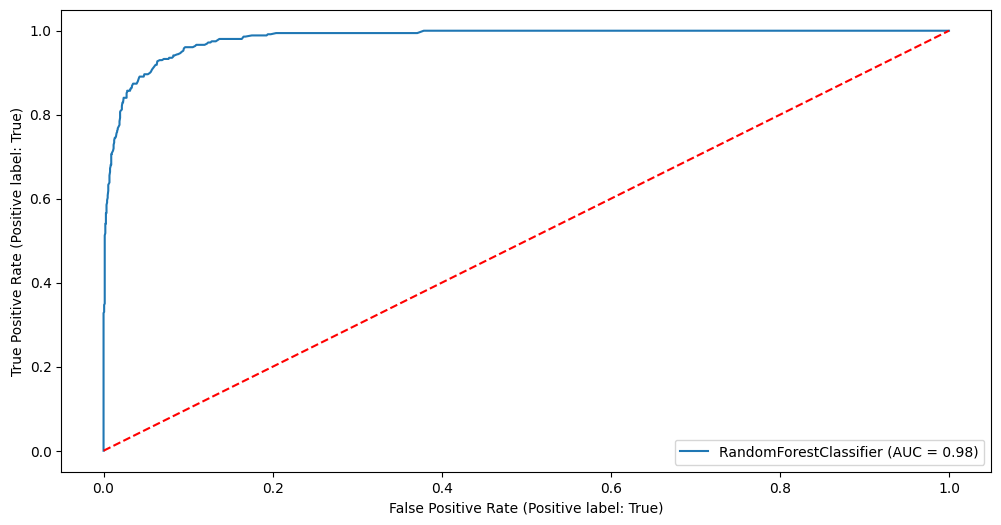

In [58]:
# The plot is not new but note the use of gs_rf.best_estimator_ 
metrics.RocCurveDisplay.from_estimator(gs_rf.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

# Boosting
Boosting-type algorithms are based on **two core principles**:
1. Develop an ensemble sequentially (i.e. add one model at a time)
2. Let the next model in the chain correct the errors of the current ensemble

We discussed two flavors of boosting in the lecture:
- **adaboost algorithm**, first instantiation of a boosting ensemble
- **gradient boosting**, proposed in the paper [Greedy Function Approximation: A Gradient Boosting Machine](https://www.jstor.org/stable/2699986?seq=1) by Jerome H. Friedman

This part of the demo notebook follows the same approach as above, we first demonstrate implementing a boosting ensemble from scratch and then showcase its use together with a professional machine learning library. Many derivatives of boosting and libraries exist. Some members of the gradient boosting family include:
- [LightGBM from Microsoft](https://lightgbm.readthedocs.io/en/latest/)
- [Catboost from Yandex](https://catboost.ai/)
- [NGBoost from Stanford ML Group](https://stanfordmlgroup.github.io/projects/ngboost/)

Given wide adoption in practice and academia, we opted for focusing the demo notebook to **extreme gradient boosting** or XGB for short. Demos for other popular boosting algorithms are available via the links above. Boosting algorithms that do not follow the gradient boosting principle may be considered somewhat old-fashioned. We will not cover them here. However, the exercises give you an opportunity to implement your own Adaboost ensemble from scratch. And of course, `sklearn` also supports adaboost and other boosting algorithms.    

## Verifying the boosting principle
Is it true really true that one model can *learn* or *correct* the errors of another model as promised by the boosting paradigm? Before diving into cutting-edge gradient boosting, let's convince ourselves of this  fundamental premise of boosting. 

For this purpose, we use the HMEQ data set and demonstrate that training a model on the errors of a previous model helps to reduce classification error. Since it is common practice to implement boosting using trees as base model, we follow this approach.  

In [25]:
from sklearn import tree

### Model training 
Here we will show the effectiveness of corrective models that *train on errors*. We will first train two models, the first will be for regular predictions. The second will predict which observations the first model misclassifies. We will first run the first prediction on test data, then correct these predictions using the second model.


In [26]:
estimators = []   # List to store the two tree models

In [27]:
# Train first classifier
clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=2, max_depth=2)  # First classifier
dt = clf.fit(X_train, y_train)  # Fit the classifier
estimators.append(('first model', dt))

Having obtained our first model, we can calculate that model's residuals on the training set. Let's consider a classification setting. More concretely, let's focus on discrete class predictions. Recall that this is the type of output that we obtain when calling the function `predict()`.  

In [28]:
initial_pred = dt.predict(X_train)  # Classify training set using first classifier

Next, we identify misclassified observations and calculate the **classification error**.

Let's produce a binary vector with the same length as the training set in which an entry of `True` indicates that the corresponding training set observation is misclassified by our first tree. The way we design our vector also makes it very easy to compute the classification error. All we need is to find the mean of that vector.

In [29]:
res = initial_pred != y_train.iloc[:, 0] 
print("Classification error of tree #1 is {:.4}".format(res.mean()))
print("Total number of errors tree #1 is", res.sum())

Classification error of tree #1 is 0.15
Total number of errors tree #1 is 626


On to model #2. Here, we train not on $y$ but a new binary target variable indicating whether model #1 classified an observation correctly. We can think of this new target as $y - \hat{y}$ ie. the residual. However, since we train on decisions of a binary outcome, this classifier will predict errors of the first classifier.

In [30]:
clf2 = tree.DecisionTreeClassifier(criterion="gini")  # instantiate second model
dt_res = clf2.fit(X_train, res)                       # note the new target, we are training on residuals
estimators.append(('second model', dt_res))           # store second model for later
dt_res

DecisionTreeClassifier()

Calling the `predict`function of our second corrective model, we obtain a prediction of which observations model #1 is likely to misclassify. 

In [31]:
likely_misclassifications = dt_res.predict(X_train) 
print("Based on model #2, we expect model #1 to misclassify {} observations.".format(
    likely_misclassifications.sum()))

Based on model #2, we expect model #1 to misclassify 626 observations.


In [32]:
# Check if classified likely misclassifications are the same as residuals
accuracy_misclassifications = likely_misclassifications == res
print(accuracy_misclassifications)

index
1230    True
2727    True
4187    True
4446    True
2513    True
        ... 
4455    True
5270    True
1263    True
1946    True
2558    True
Name: BAD, Length: 4172, dtype: bool


In [33]:
# It seems likely misclassifications are exactly congruent with residuals, so the model does work
accuracy_misclassifications.mean() 

1.0

### Model testing

Now that we have our two models, we will begin using the test data to see if a combination of the two models can reduce the value of the residuals. We will first predict y using X_test.

In [34]:
pred_initial_test = dt.predict(X_test)

In [35]:
res_test = pred_initial_test != y_test.iloc[:, 0]
print("Test error of model 1: {:.4}".format(res_test.mean()))

Test error of model 1: 0.1454


Now we predict for which observations model 1 has likely made an error.

In [36]:
likely_misclassifications_test = dt_res.predict(X_test)
likely_misclassifications_test

array([False, False,  True, ...,  True, False,  True])

Lastly, we correct the likely misclassifications by simply flipping the predicted (from model 1) class label.

In [37]:
pred_corrected = pd.Series(pred_initial_test)
pred_corrected[likely_misclassifications_test] = ~ pred_corrected[likely_misclassifications_test]

In [38]:
pred_initial_test[likely_misclassifications_test]  # Check that they have actually been changed

array([False, False,  True,  True, False,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True, False, False, False, False,
        True,  True, False,  True,  True, False,  True, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True, False, False, False,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False,  True,

In [39]:
pred_corrected[likely_misclassifications_test]  # all the results are opposite, so this worked!

2        True
5        True
18      False
19      False
30       True
        ...  
1763     True
1764    False
1783    False
1785     True
1787     True
Length: 231, dtype: object

Time for the grand final, did we reduce the test error?

In [40]:
res_corrected = np.array(pred_corrected) != y_test.iloc[:,0]
print("Test error after corrected model 1 by model 2: {:.4}".format(res_corrected.mean()))

Test error after corrected model 1 by model 2: 0.1281


Hurray!!!

A lower test error indicates that our process worked. We were able to lower the error on a test set using a second model which focused on identifying misclassified cases. Let's now examine how gradient boosting relies on similar principles but is a bit more complex in execution.

## Gradient Boosting from scratch

Gradient boost is one specific form of boosting (using residuals recursively to increase accuracy). This process begins with an initial simple prediction which is often the mean of the target variable. After, the algorithm iteratively goes through every feature and determines which feature will best reduce this error with a single split. This is essentially a single level tree, or stump. This stump is then chosen and added to the ensemble. Next, residuals are calculated once again and the process continues for as many iterations as deemed necessary.

We can implement this procedure from scratch as well to examine how it works. The original code for this exercise can be seen [here](https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-4a3d9077367). It has been adapted for this lesson.  We will first use the same data set that we generated in demo notebook 3 for classification. Our Gradient Boost will also be a classification example. Keep in mind that regression is possible too!

In [41]:
np.random.seed(888)

In [42]:
# Create synthetic dataset, same as demo notebook 3

class1_x = np.random.normal(loc=1, scale=1, size=1000)
class1_y = np.random.normal(loc=1, scale=1, size=1000)

class2_x = np.random.normal(loc=4, scale=1, size=1000)
class2_y = np.random.normal(loc=4, scale=1, size=1000)

lab1 = np.repeat(0, 1000)
lab2 = np.repeat(1, 1000)

class1 = np.vstack((class1_x, class1_y)).T
class2 = np.vstack((class2_x, class2_y)).T

data = np.vstack((class1,class2))

labels = np.concatenate((lab1,lab2))

data[:5,:]

array([[ 0.82379913,  0.52703441],
       [ 1.18887636,  0.46382642],
       [ 1.82674718,  0.36148983],
       [ 0.96755269, -0.40695666],
       [ 0.34750058,  1.73195855]])

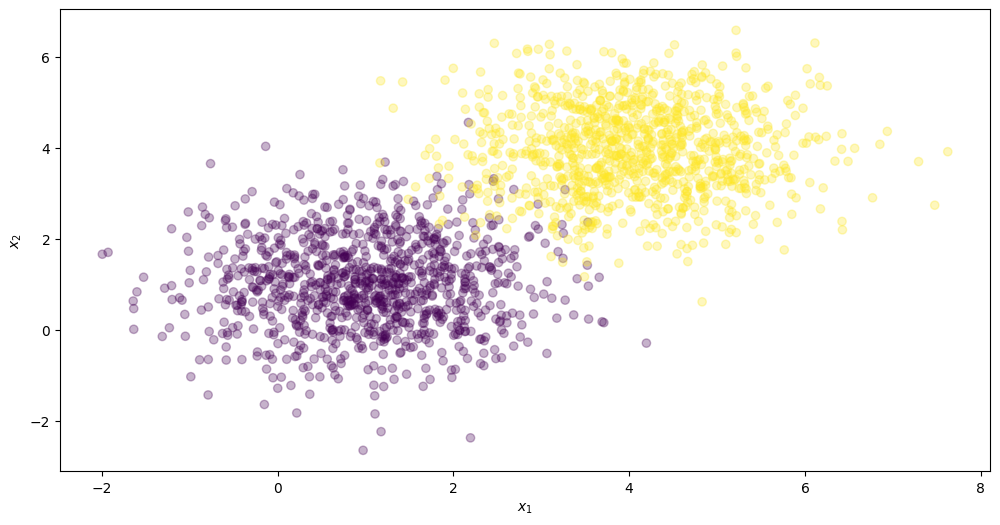

In [43]:
# Visualization of data set

plt.scatter(data[:,0], data[:,1], c=labels, alpha=.3);
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

To begin gradient boost, we first need a loss function to quantify the difference between the predicted y values and the true y values. This loss function must be differentiable to obtain the gradient. This loss function will determine how the function and its derivative (the gradient) creates future stumps for our gradient boost forest.

In [44]:
def compute_loss(y, pred_y): 
    return ((y - pred_y) ** 2) / 2

In [45]:
def loss_gradient(y, pred_y): 
    return -(y-pred_y)

Now that we have our loss and gradient functions, we can begin with the gradient boost algorithm. The first step in the algorithm is to create an initial prediction. Generally, this is the mean of the labels. Next, residuals are calculated by using the `loss_gradient` function and a shallow single level decision tree or decision 'stump' is created based on these residuals. Residuals are then recalculated and this process repeats iteratively.

In [46]:
from sklearn.tree import DecisionTreeRegressor 

def gradient_boost_algorithm(X, y, iter=10): 
    forest_of_stumps = [] 
    pred_y = np.array([y.mean()]*len(y))  # Predict mean for all observations
    pred_y_initial = pred_y 
    print(compute_loss(y, pred_y).mean()) 
    for i in range(iter): 
        residuals = -loss_gradient(y, pred_y)  # Calculate residuals using the gradient function
        stump = DecisionTreeRegressor(max_depth=1)
        stump.fit(X, residuals)  # Feed data and residuals to the decision tree function (stump since it has a depth of only 1)
        forest_of_stumps.append(stump)  # Add this tree to the forest
        new_pred_y = stump.predict(X)  # Make new predictions and repeat this process over the specified number of iterations
        pred_y = pred_y + new_pred_y 
        print(compute_loss(y, pred_y).mean())
    return forest_of_stumps, pred_y_initial

The final function will be to predict classes using our algorithm. We will first run new observations through our forest of stumps sequentially and add their predictions together. At this point, the tree will return probabilities that each observation will be of class `1`. If we want a class prediction rather than probabilities of class `1`, we can compare each prediction to some threshold value (defaulted at `0.5`). Predictions over the threshold will be considered class `1` predictions while all others will be class `0`.

In [47]:
def gbm_predict(forest_of_stumps, pred_y_initial, X, predict_class=False, threshold=0.5): 
    pred_y = np.array([pred_y_initial[0]]*len(X))
    for stump in forest_of_stumps: 
      pred_y = pred_y + stump.predict(X)  # Navigate the forest sequentially adding the predictions from each stump along the way
      pred_y = np.where(pred_y<0, 0, pred_y)
      pred_y = np.where(pred_y>1, 1, pred_y) 
    if predict_class:
      pred_y = pred_y > threshold
      pred_y = np.where(pred_y==False, 0, pred_y)
      pred_y = np.where(pred_y==True, 1, pred_y) 
    return pred_y

Now we can train our model using these functions. Each loop within the function will print the mean of the loss function so we can verify that it is actually decreasing. You can adjust iteration number to allow a larger forest of stumps in the gradient boost forest.

In [48]:
stumps, pred_y_initial = gradient_boost_algorithm(data, labels, iter=10)

0.125
0.028301419238567247
0.02345766189417778
0.020762059308151854
0.018699488395621827
0.017682921322778985
0.01670758697552558
0.016233586287342353
0.015628097506118023
0.015281764309078226
0.014965850618216177


In [49]:
pred_y_initial

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [50]:
stumps

[DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1)]

We can now use these stumps to make a prediction on the data.

In [51]:
pred_class = gbm_predict(stumps, pred_y_initial, data, predict_class=True)

print(pred_class)

[0 0 0 ... 1 1 1]


In [52]:
pred_prob = gbm_predict(stumps, pred_y_initial, data, predict_class=False)

print(pred_prob)

[0.00217072 0.00217072 0.06504736 ... 0.98424957 0.98424957 0.98424957]


We can also assess the mean error on the labels which is very low. Therefore, we can see this method works very well to separate classes.

In [53]:
res_gradient_boost = pred_class != labels
print("The average error is", res_gradient_boost.mean())
print("The total number of errors is" , res_gradient_boost.sum(), "of", len(res_gradient_boost), "predictions in total")

The average error is 0.0345
The total number of errors is 69 of 2000 predictions in total


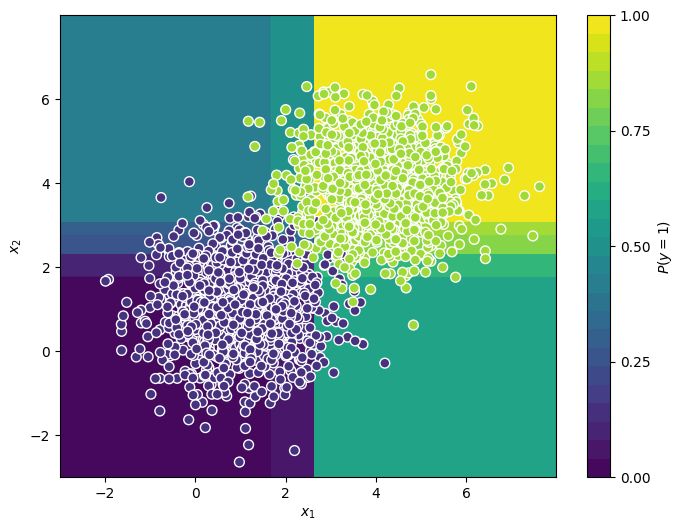

In [54]:
# Graph to depict probability predictions of the logit model

xx, yy = np.mgrid[-3:8:.01, -3:8:.01]  # create input data for our logit model using mgrid
grid = np.c_[xx.ravel(), yy.ravel()]   # then transform the data into our standard format

# Calculate logit probability predictions
probs = gbm_predict(stumps, pred_y_initial, grid, predict_class=False)

# Reshape to facilitate plotting
probs = probs.reshape(xx.shape)

# Plot logit predictions
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25,  vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

# Plott the actual data points
# We alter the format of the scatter plot to ensure that data points are visible
ax.scatter(data[:,0], data[:,1], c=labels, s=50, vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1);  
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

## XGBoost with xgb library 
Different gradient boosting algorithms exist and different implementations exist of each of those. If you want to use the *original gradient boosting machine* as proposed in [Friedman's 2001 paper](https://www.jstor.org/stable/2699986?seq=1) or his [follow-up paper on stochastic gradient boosting](http://dx.doi.org/10.1016/S0167-9473(01)00065-2), we recommend using the class `sklearn.ensemble.GradientBoostingClassifier`. It offers a lot of flexibility (e.g., hyperparameters) and is[ very well documented](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). However, for later data sets, you might want to use **extreme gradient boosting (XGB)**, which was explicitly designed for highly scalable gradient boosting. Below, we demonstrate application of XGB to our credit risk data set.

Although `sklearn` does have a version of this algorithm, it is actually common to use the `xgboost` library for training XGB models. To be precise, `sklearn` offers an implementation of XGB but it might not incorporate the latest features. As far as the use is concerned, you will not notice any differences between the `xgboost` library and `sklearn`. However, **you might need to install the `xgboost` library before moving on**.

### Tuning XGB hyperparameters
Our modeling pipeline is exactly as before in the RF example, and in general. We tune hyperparameters using grid-search and cross-validating the training data. Once we determined good hyperparameter settings, we train a XGB model with the corresponding configuration on the entire training set and obtain test set prediction, which we assess using ROC analysis. 

In [55]:
import xgboost as xgb
    # Setting up the grid of meta-parameters
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.5, 0.9, 5),  # random subspace
    'n_estimators': [100, 200],  # ensemble size or number of gradient steps
    'max_depth': [5, 10],   # max depth of decision trees
    'learning_rate': [0.1, 0.01]}  # learning rate

gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)
gs_xgb.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'learning_rate': [0.1, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [56]:
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)

# Find test set AUC of the best XGB classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_xgb.predict_proba(X_test)[:, 1])
print('XGB test set AUC with optimal meta-parameters: {:.4f}'.format(metrics.auc(fp_rate, tp_rate) ))

Best CV AUC: 0.9558
Optimal XGB meta-parameters:
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGB test set AUC with optimal meta-parameters: 0.9624


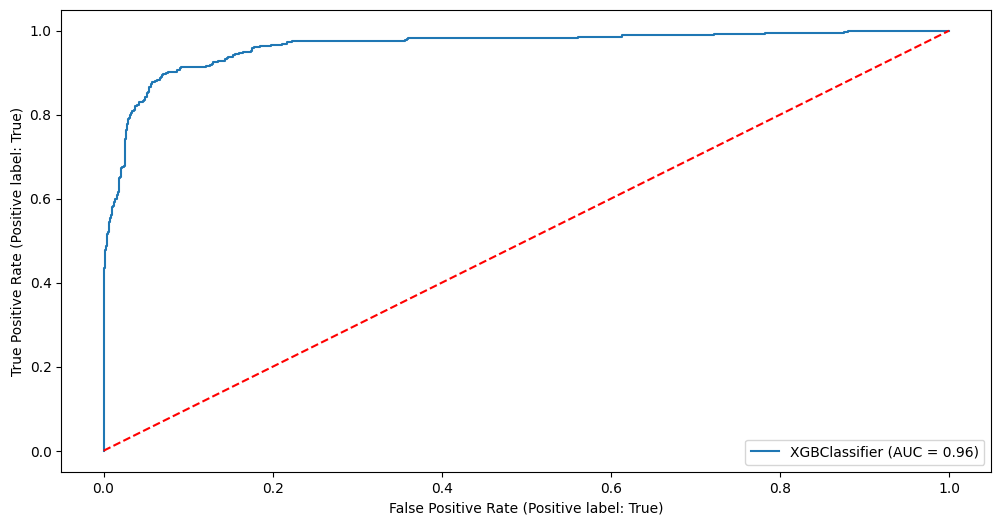

In [57]:
# The plot is not new but note the use of gs_xgb.best_estimator_ 
metrics.RocCurveDisplay.from_estimator(gs_xgb.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

The XGB models completes our journey through the space of ensemble learning algorithms. We have now covered the maybe most important of-the-shelf machine learning algorithms and you have seen how we can apply them to real-world data. 

In future demo notebooks, we will go back to other steps in the machine learning pipeline and learn about yet more possibilities and procedures to derive value from data.